# Lab 3 - Brownian Motion

# 3.4 - Data Collection 

The method of data analysis for this lab was to use a microscope with a camera attached to focus on some micrometer scale silica spheres in water. We then set the camera to record an image every second for 240 seconds. These images were then used to create a 1 FPS timelapse, which is our "dataset". After recording the video we used trackpy to turn the video into csv files for each particle. This involved using trackpy to select the spheres in the video, and follow them as they move. The important parameters to get good data were mass and radius. Finding the ideal balance of mass and radius is what allows us to get good data and prevent trackpy from following any dark spot on the video. The radius and mass we used were a mass of 300, and a radius of 15 pixels. Our data seemed reasonably good and none of the 10 longest running datasets seemed to display "Stuck" behavior when plotted on the lab computer.


# 3.5.1 Calibration Analysis

In order to convert the measurements taken by trackpy into micrometers to do meaningful data analysis we had to use a calibration image to calculate a value for the conversion between pixels and microns. The method for doing this calibration involved setting up the microscope and focusing it using the 40x magnification lens to center the image on the camera. A picture was taken, and using the given measurement of the increments between each line on the calibration slide which was 10 microns per line. We then used matplotlib to plot vertical and horizontal lines that correspond to the lines printed on the image. Usin these lines we can find the distance between the lines on the image in microns, and using the calibration slides 10um distance we now have the ratio of microns to pixels. To extract an estimate of the uncertainty I then played around with the distance in pixels across the lines printed on the calibration slide, knowing that we could then say that the uncertainty is the amount of pixels where we could still be on the line but not be exactly centered. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import pandas as pd

Read in calibration image from files and then plot it in the notebook.

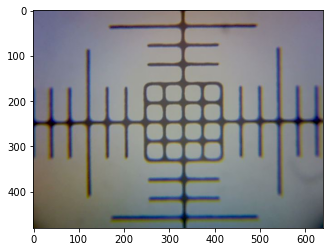

In [2]:
img = mpimg.imread("/Users/henryaxon/Downloads/391Files/Lab3/my_calibration_image.jpg")
plt.imshow(img);

This is in color, with three values per pixel. Note that the total size is 640x480 (which matches the resolution of the original image.  Lets try turning this into greyscale to improve the contrast.

In [3]:
def as_grey(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

greyimg = as_grey(img)

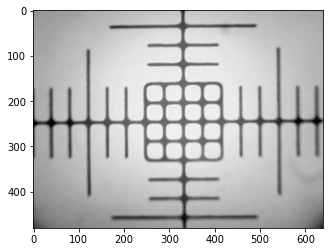

In [4]:
plt.imshow(greyimg, cmap='gray');

Now we can draw lines at particular coordinates to match the features on the image.  Knowing that each line on the target is 10 um apart, this allows us to calibrate our image microns/pixel by finding the distance in pixels and the calibrated distance in microns between lines.



Ultimately the measurement that I found was that the lines I chose are 335 pixels apart with 80 um between the two marks so the microns per pixel is 80um/335 = um/pixel

0.23880597014925373


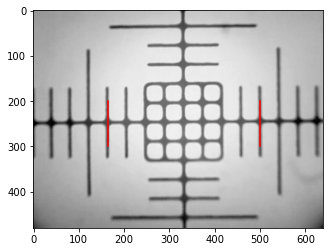

In [5]:
plt.imshow(greyimg, cmap='gray')

# These values are the x positions of the lines (in pixels)
# Adjust these to match lines on the calibration target
x1 =  165
x2 = 500
yrange = [200,300] # Control the vertical size of the lines
plt.plot([x1,x1],yrange,'r');
plt.plot([x2,x2],yrange,'r');
umperpixelx = 80/335
print(umperpixelx)

We can also do this in the y direction.  Camera pixels are not guaranteed to be perfectly square, so we need to see if our different directions need to be converted by different factors.

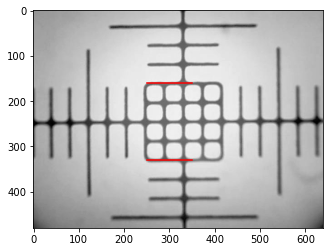

In [6]:
plt.imshow(greyimg, cmap='gray')

# These values are the x positions of the lines (in pixels)
# Adjust these to match lines on the calibration target
y1 =  160
y2 = 330
xrange = [250,350] # Control the vertical size of the lines
plt.plot(xrange,[y1,y1],'r');
plt.plot(xrange,[y2,y2],'r');

In [7]:
differencey = y2-y1
umy = 40
umperpixely = umy/differencey

In [8]:
print(umperpixely)

0.23529411764705882


I got very close but slightly different measurements but using the range of pixel values which allow the lines to be on the calibration lines which i measured to be about +/- 2 pixels,so a range of 4 pixels and thus the uncertianty in our measurments of x and y um/pixel will be simply uncertainty y = errorrange/pixelrange * measurement. This uncertainty can be added with the other sources of error that we estimate in calculating the diffusion constant. In reality they are insignifigant when compared to other sources of error, but it can still help to get a better estimate of error.

In [9]:
uncertaintypixels = 2
uncertaintyumpixelsx = (uncertaintypixels/(x2-x1))*umperpixelx
uncertaintyumpixelsy = (uncertaintypixels/differencey)*umperpixely

In [10]:


print(f'The calibration factor in the x-direction is:{umperpixelx:.3} +/- {uncertaintyumpixelsx} um/pixel.')
print(f'The calibration factor in the y-direction is:{umperpixely:.3} +/- {uncertaintyumpixelsy} um/pixel.')


The calibration factor in the x-direction is:0.239 +/- 0.0014257072844731566 um/pixel.
The calibration factor in the y-direction is:0.235 +/- 0.002768166089965398 um/pixel.


# 3.5.2 Dispersion Analysis

Now that we have found the conversion factor in the x and y directions we want to find diffusion constant by using width of the gaussian/binomial distribution of the x and y displacements. The first step that I took was to write functions for conversions in the x and y direction, and read the datasets for x and y positions in as pixels before converting to microns. 

After converting to microns and creating arrays of the data, which are then used to find the displacement in x and y in each frame we can then plot the data in histograms to check that the data we found is roughly a gaussian and centered at 0. From these x and y histograms we are able to determine a value for both the mean as well as the standard deviation and then find the errors on these values. Most important is the error on the standard deviation as this is the primary error used in our calculation of the diffusion constant. 

The error in the mean was found using the standard error of the mean formula, and then this error is used to determine if our datasets are consistent with a mean displacement of 0. After doing this in the next few lines, we can say that yes, both datasets have means which are consistent with 0.

The standard deviations where calculated, and then the error was found using the formula for the the relative error of standard deviation - SDError = 1/sqrt(2(N-1)). We used this to check that the standard deviations in the x and y directions are consistent. Which will be clear in the lines below

Use Kelvin for temp. T room = 295 kelvin +/- 5 degrees kelvin - will be an insignifigant error in the lab

Below I needed to write a function to convert our pixel data into microns 

In [11]:
def pixeltoumx(Datax):
    MicronsDatax = []
    for i in Datax:
        Microns = i * umperpixelx
        MicronsDatax.append(Microns)
    return MicronsDatax




In [12]:
def pixeltoumy(Datay):
    MicronsDatay = []
    for i in Datay:
        Micronsy = i * umperpixely
        MicronsDatay.append(Micronsy)
    return MicronsDatay


This was when we used a lab computer to apply trackpy library in order to track particles of mass = 300, and a radius of 15 pixels to track parcticles moving throughout out the 1FPS movie. Our data seemed reasonably good and none of the 10 longest running datasets seemed to display "Stuck" behavior. 

At this point we have now used a lab computer to extract the CSV files from the movie and have each chosen a trajectory to follow. I will be using trajectory 65 due to its longer length as compared to some of the other datasets. 

In [13]:
TrackData = pd.read_csv('trajectory_91.csv')

In [14]:
TrackData.head()

,frame,x,y
0,1,51.621864,201.271279
1,2,50.399520,207.742931
2,3,47.535938,207.012373
3,4,44.390405,201.540974
4,5,40.320795,199.825691


Now that the CSV of the data has been read into the notebook I will create arrays in order to be able to analyze the change in x and y directions over every second of the video.

In [15]:

# Turn the dataframe into a simple vector using values
yvec = TrackData['y'].values
yvecum = np.array(pixeltoumy(yvec))
# Find the difference in xvec by some number of frames in the video 
offset = 1
ydiff = yvecum[offset:]-yvecum[:-offset]
len(ydiff)



xvec = TrackData['x'].values
xvecum = np.array(pixeltoumx(xvec))
# Find the difference in xvec by some number of frames in the video 
offset = 1
xdiff = xvecum[offset:]-xvecum[:-offset]

sdy = np.std(ydiff)
sdx = np.std(xdiff)
Errordx = uncertaintyumpixelsx
Errordy = uncertaintyumpixelsy

#Because the error in each measurement of dx is not independent, the error in the change will be the same as the calibration error which is our error on dx.
N= 2*190
SDErrorFrac = (1)/(np.sqrt(N))
print(SDErrorFrac)
SDErrorAbsx = sdx*SDErrorFrac
SDErrorAbsy = sdy*SDErrorFrac

print("Error on Standard Deviation X is:", SDErrorAbsx,'um')
print("Error on Standard Deviation Y is:", SDErrorAbsy, "um")

0.051298917604257706
Error on Standard Deviation X is: 0.03465975475733589 um
Error on Standard Deviation Y is: 0.03839265607891586 um


Below I plotted the deltax and deltay data as histograms in order to show that the data is consistent with brownian motion. We want to see an average displacement of 0, and for the standard deviations to be consistent with each other. We need to find error on both our values of the mean as well as the error in the standard deviation. 

The error in our measurements of the mean change in x and y will come from the x, and y calibration error, as well as the standard error of the mean. 

While the standard deviation error will come from the formula for relative error on standard deviation. 

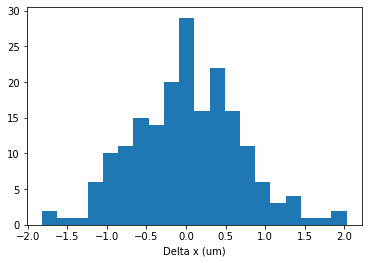

The error in the mean displacement as calculated by using the Standard error of the mean method is 0.048887811944768884
SD x: 0.676+/- 0.0347 um
Mean x: 0.0189 +/- 0.0489 um


In [16]:

plt.hist(xdiff, 20)
plt.xlabel('Delta x (um)')
plt.show()
sdx = np.std(xdiff)
#FracErrorSD = 1/(np.sqrt(2(191)))

Errordx = uncertaintyumpixelsx
ErrorSEMx = sdx/np.sqrt(191)
#print("The error in displacement that would affect all measurements systematically is the error from the calibration slide:", Errordx)
print("The error in the mean displacement as calculated by using the Standard error of the mean method is", ErrorSEMx)

Meanx = np.mean(xdiff)
print (f"SD x: {sdx:.3}+/- {SDErrorAbsx:.3} um")
print(f"Mean x: {Meanx:.3} +/- {ErrorSEMx:.3} um")



Now I did the same for the y data

In [17]:
yvec = TrackData['y'].values
yvecum = np.array(pixeltoumy(yvec))
# Find the difference in xvec by some number of frames in the video 
offset = 1
ydiff = yvecum[offset:]-yvecum[:-offset]
len(ydiff)

191

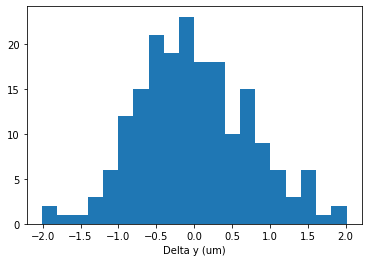

The error in displacement as calculated by using the Standard error of the mean method is 0.05415309379963127
SD y: 0.748 +/- 0.0384um
Mean y: -0.00353 +/- 0.0542um


In [18]:
plt.hist(ydiff, 20)
plt.xlabel('Delta y (um)')
plt.show()


sdy = np.std(ydiff)
Meany = np.mean(ydiff)

#Errordy = uncertaintyumpixelsy
ErrorSEMy = sdy/np.sqrt(191)
#print("The error in displacement that would affect all measurements systematically is the error from the calibration slide:", Errordy)
print("The error in displacement as calculated by using the Standard error of the mean method is", ErrorSEMy)
print (f"SD y: {sdy:.3} +/- {SDErrorAbsy:.3}um")
print(f"Mean y: {Meany:.3} +/- {ErrorSEMy:.3}um")



These are the absolute errors from finding the fractional errors in the measurement of the standard deviation of the sample in um. Next, knowing that our conversion of the data from pixels into microns has an uncertainty, I added this systemic error to the error on the standard deviation in both the x and y directions. I added them in quadrature to find the total error on the standard deviation. 

This step may not be entirely necessary, as the change is very minor.

In [19]:
TotalErrorSDX = np.sqrt(((SDErrorAbsx)**2) + ((uncertaintyumpixelsx)**2))
TotalErrorSDY = np.sqrt(((SDErrorAbsy)**2) + ((uncertaintyumpixelsy)**2))

print(f"The total error on the standard deviation of our displacement distribution for the x direction is {TotalErrorSDX:.3} um ")
print(f"The total error on the standard deviation of our displacement distribution for the y direction is {TotalErrorSDY:.3} um ")

The total error on the standard deviation of our displacement distribution for the x direction is 0.0347 um 
The total error on the standard deviation of our displacement distribution for the y direction is 0.0385 um 


Next I found the X and Y Variance values for SD^2. In order to find the x and y variance errors, we need to convert the error on standard deviation back to fractional uncertainty and because our measurement is raised to a power we will need to multiply the fractional error by that power.

In [20]:
#Converting previous total SD uncertainty back to fractional uncertainty for propogation
TotalSDErrorFracx = TotalErrorSDX/sdx
TotalSDErrorFracy = TotalErrorSDY/sdy

VarianceX = (sdx)**2
VarianceY = (sdy)**2

#Errors in Variance using the fractional total error on the standard deviation
ErrorVariancexfrac = TotalSDErrorFracx*2
ErrorVarianceyfrac = TotalSDErrorFracy*2
#Converting Variance Fractional Error back to absolute error for propagation by rules for dealing with numbers wihtout uncertainties
ErrorVarianceAbsx = ErrorVariancexfrac*VarianceX
ErrorVarianceAbsy = ErrorVarianceyfrac*VarianceY

#Printing the experimental variance with uncertainties  
print(f'The variance in the x direction is {VarianceX:.3}+/- {ErrorVarianceAbsx:.3}um^2.')
print(f'The variance in the y direction is {VarianceY:.3}+/- {ErrorVarianceAbsy:.3}um^2.')

The variance in the x direction is 0.456+/- 0.0469um^2.
The variance in the y direction is 0.56+/- 0.0576um^2.




Now in order to find diffusion we will use these variance values to calculate the dispersion from the relation:

σ2 = 2D∆t, and to do this we will need to first find the x and y dispersion constants and add them in quadrature.

So dispersion is equal to variance / 2delta t

Next to find the error on the dispersions in both directions we will want to apply the rule for division of a measurement by a constant. The constant in this case is 2deltaT, which is 2 in this case. What this means is that the relative error will remain the same, however the total error will be divided by 2 based on the rule for dealing with exact numbers.

In [21]:
Dispersionx = VarianceX/2
Dispersiony = VarianceY/2

AbsDispersionxError = ErrorVarianceAbsx/2
AbsDispersionyError = ErrorVarianceAbsy/2

DispersionConstant = (Dispersionx + Dispersiony)/2
AbsDispersionError = (np.sqrt((AbsDispersionxError)**2 + (AbsDispersionyError)**2))/2 


print(f'The Dispersion in the x direction is {Dispersionx:.3}+/- {AbsDispersionxError:.3}um^2/s.')
print(f'The Dispersion in the y direction is {Dispersiony:.3}+/- {AbsDispersionyError:.3}um^2/s.')
print(f'The Dispersion constant overrall is {DispersionConstant:.3}+/- {AbsDispersionError:.3}um^2/s.')
RMS1s = np.sqrt(4*DispersionConstant)

The Dispersion in the x direction is 0.228+/- 0.0234um^2/s.
The Dispersion in the y direction is 0.28+/- 0.0288um^2/s.
The Dispersion constant overrall is 0.254+/- 0.0186um^2/s.


Now to find the overrall dispersion constant we add the x and y components in quadrature and to find the error on this measurement we do the same. Looking at the errors we can say that the dominant error in calculating dispersion is the standard deviation. While the calibration slide did introduce a systematic error, when added in quadrature it is insignifigant compared to the error in the standard deviation. 

In [22]:
DispersionConstant = (Dispersionx + Dispersiony)/2
AbsDispersionError = (np.sqrt((AbsDispersionxError)**2 + (AbsDispersionyError)**2))/2 

print(f'The Dispersion constant overrall is {DispersionConstant:.3}+/- {AbsDispersionError:.3}um^2/s.')

The Dispersion constant overrall is 0.254+/- 0.0186um^2/s.


# 3.5.3 Boltzmann Constant Df = KbT

Now we need to use the diffusion to determine the Boltzmann constant. To do this we have measurements of Temperature with uncertainties, as well as measurements of viscocity which will be assumed to be a measurement of negligible uncertianty, and a measurement of the radius of the particles which we know, given that the diameter of the spheres is 1.02 um with negligible uncertainty. To properly apply this formula we will also need to ensure that all values are in terms of base units. Specifically we will need to convert the dispersion into meters from um to get a correct value for the Boltzman constant.


The value for the temperature is the temperature in the room where data was collected - in this case about room temperature so 295 +/- 5 K.

r = 1.02/2 +/- 0.01 um

T = 295 +/- 3 Kelvin

Viscocity of water = 1 * 10^-3 Pa s +/- .00025 Pa s (This uncertainty value is that which is reccomended by NIST)

D = 0.25 +/- 0.019 um




In order to solve for the Boltzman constant we need to rearrange the equation, to solve it as Kb = Df/T. In this case f is itself a value with uncertianties and is a value we need to calculate. The formula for f(drag coefficient) is. - f = 6pi* mu *r. As we see above, we will need to use the values above to calculate the drag coefficient, and then propagate the uncertainties on radius and viscocity of water. After finding the drag and its uncertainties, we can then find the Boltzman constant and use this uncertainty along with errors on temperature and dispersion to find the error on our determination of the Boltzman constant.

Propagation formula f:
Errorf  = sqrt((df/dr)(errorr))^2 + ((df/dviscocity)(errorViscocity))^2)

= sqrt((6piViscosity)(errorr))^2 + ((6piRadius)(errorViscocity))^2)

Propagation Formula Kb:

ErrorKb = Sqrt(((dKb/dT)(errorT))^2 + ((dKb/df)(errorf))^2 + ((dKb/dD)(errorD))^2)

ErrorKb. = Sqrt(((-Df/T^2)(errorT))^2 + ((D/T)(errorf))^2 + ((f/T)(errorD))^2)

This formula is for propagating the errors on our value of Kb. I hope it is clear enough. the d in each derivative is meant to represent the symbols for partial derivatives with respect to each measured value. I then in the second version found each partial derivative. 

In [23]:
# Calculation of f(drag) f = 6piRmu
R = (5.1)*(10**-7)
Rerror = 10**(-6)

Viscocity = 10**(-3)
ViscocityError = .00025
Drag = 6*np.pi*R*Viscocity
dDragdV = 6*np.pi*R
dDragdR = 6*np.pi*Viscocity

#To find the error in f, I will apply the general formula to get a maximum estimate. 
ErrorDrag = np.sqrt((((dDragdV)*(ViscocityError))**2) + (((dDragdR)*(Rerror))**2))

#Printing the value of drag in our experiment, and its error as propagated above.
print(f'The value of the drag constant is {Drag:.3} +/- {ErrorDrag:.3} kg/s.')



The value of the drag constant is 9.61e-09 +/- 1.9e-08 kg/s.


Now that we have a value of the drag constant and of its uncertainty we can now use that value and our other values to calculate the Botlzman constant. In this section of calculation I initially made some mistakes leading to an incredible discrepancy however after correcting all measurements of errors and of values to meters I was able to get the results below, which suggest as measurement of the Boltzman constant within a standard deviation of the actual Kb.

In [24]:
#Kb = Df/T
T = 295
D = (DispersionConstant)*(10**-6)
f = Drag

dKdt = -D*f/(T**2)
dkdf = D/T
dkdD = f/T
ErrorDmeters = (AbsDispersionError)*(10**-6)


ErrorKb = np.sqrt((((dKdt)*(5))**2)+(((dkdf)*(ErrorDrag))**2)+(((dkdD)*(ErrorDmeters))**2))



BoltzmanConstant = (D*f)/T
print(f'The experimental Boltzmann constant is {BoltzmanConstant} +/- {ErrorKb} J/K')
expectedBoltzmann = 1.38*(10**-23)


The experimental Boltzmann constant is 8.282177006984018e-18 +/- 1.6382808605589656e-17 J/K


Now to analyze our result we can find the number of standard deviations away from the expected Boltzmann constant that we are using xbest - x expected / sigma. 


In [25]:
StdAway = (BoltzmanConstant - expectedBoltzmann) / ErrorKb

print(f'Our experimental value of the Boltzman Constant is {StdAway:.3} standard deviations from the expected value')

Our experimental value of the Boltzman Constant is 0.506 standard deviations from the expected value


Using the probabilities table in the textbook I found that the probability of a value being outside of .505 standard deviations from the expected value is 58.23%. This suggests that our experimental value is a reasonable calculation within the errors that I calculated. But it is still a very large difference in the values themselves.

# 3.5.4 Time Evolution

For the time evolution component of the assignment I set differing offsets to calculate the standard deviations of the data at a delta t setting of 2, 4 ,6 ,8 , 10 and plot them 

In [26]:
RMS1s = (sdx**2+sdy**2)/2
SDxfrac = SDErrorAbsx/(sdx)
SDyfrac = SDErrorAbsy/(sdy)

RMSxfrac = SDxfrac*2
RMSyfrac = SDyfrac*2

RMSxabs = RMSxfrac*(sdx**2)
RMSyabs = RMSyfrac*(sdy**2)

RMS1Error = np.sqrt(((RMSxabs)**2)+((RMSyabs)**2))

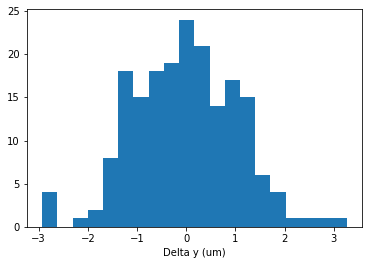

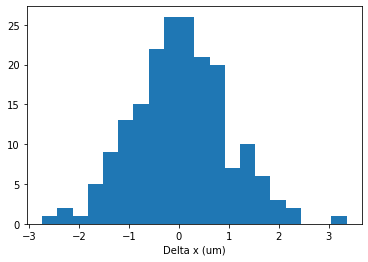

SD y: 1.07 +/- 0.0548um
Mean y: -0.0169 +/- 0.0542um
SD x: 0.977+/- 0.0501 um
Mean x: 0.0189 +/- 0.0489 um


In [27]:
#Time interval 1 2Deltat
xvec = TrackData['x'].values
xvecum = np.array(pixeltoumx(xvec))
# Find the difference in xvec by some number of frames in the video 
offset = 2
xdiff2 = xvecum[offset:]-xvecum[:-offset]


yvec = TrackData['y'].values
yvecum = np.array(pixeltoumy(yvec))
# Find the difference in xvec by some number of frames in the video 
offset = 2
ydiff2 = yvecum[offset:]-yvecum[:-offset]

N= 2*len(xdiff2)
SDErrorFrac = (1)/(np.sqrt(N))


plt.hist(ydiff2, 20)
plt.xlabel('Delta y (um)')
plt.show()
sdy2 = np.std(ydiff2)

plt.hist(xdiff2, 20)
plt.xlabel('Delta x (um)')
plt.show()
sdx2 = np.std(xdiff2)
#FracErrorSD = 1/(np.sqrt(2(191)))
SDErrorAbsx2 = sdx2*SDErrorFrac
SDErrorAbsy2 = sdy2*SDErrorFrac

Meany = np.mean(ydiff2)
print (f"SD y: {sdy2:.3} +/- {SDErrorAbsy2:.3}um")
print(f"Mean y: {Meany:.3} +/- {ErrorSEMy:.3}um")

Meanx = np.mean(xdiff)
print (f"SD x: {sdx2:.3}+/- {SDErrorAbsx2:.3} um")
print(f"Mean x: {Meanx:.3} +/- {ErrorSEMx:.3} um")

RMS2s = (sdx2**2+sdy2**2)/2


SDx2frac = SDErrorAbsx2/(sdx2)
SDy2frac = SDErrorAbsy2/(sdy2)

RMSx2frac = SDx2frac*2
RMSy2frac = SDy2frac*2

RMSx2abs = RMSxfrac*(sdx2**2)
RMSy2abs = RMSyfrac*(sdy2**2)

RMS2Error = np.sqrt(((RMSx2abs)**2)+((RMSy2abs)**2))

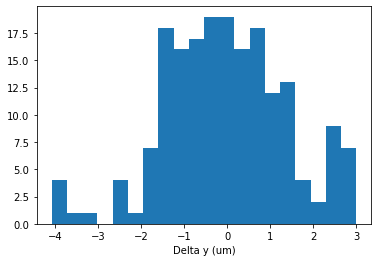

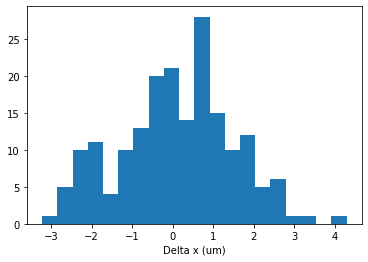

SD y: 1.43 +/- 0.0736um
Mean y: -0.0338 +/- 0.0542um
SD x: 1.41+/- 0.0725 um
Mean x: 0.0898 +/- 0.0489 um


In [28]:
xvec = TrackData['x'].values
xvecum = np.array(pixeltoumx(xvec))
# Find the difference in xvec by some number of frames in the video 
offset = 4
xdiff4 = xvecum[offset:]-xvecum[:-offset]


yvec = TrackData['y'].values
yvecum = np.array(pixeltoumy(yvec))
# Find the difference in xvec by some number of frames in the video 
offset = 4
ydiff4 = yvecum[offset:]-yvecum[:-offset]

N= 2*len(xdiff4)
SDErrorFrac = (1)/(np.sqrt(N))


plt.hist(ydiff4, 20)
plt.xlabel('Delta y (um)')
plt.show()
sdy4 = np.std(ydiff4)

plt.hist(xdiff4, 20)
plt.xlabel('Delta x (um)')
plt.show()
sdx4 = np.std(xdiff4)
#FracErrorSD = 1/(np.sqrt(2(191)))
SDErrorAbsx4 = sdx4*SDErrorFrac
SDErrorAbsy4 = sdy4*SDErrorFrac

Meany = np.mean(ydiff4)
print (f"SD y: {sdy4:.3} +/- {SDErrorAbsy4:.3}um")
print(f"Mean y: {Meany:.3} +/- {ErrorSEMy:.3}um")

Meanx = np.mean(xdiff4)
print (f"SD x: {sdx4:.3}+/- {SDErrorAbsx4:.3} um")
print(f"Mean x: {Meanx:.3} +/- {ErrorSEMx:.3} um")

RMS4s = (sdx4**2+sdy4**2)/2


SDx4frac = SDErrorAbsx4/(sdx4)
SDy4frac = SDErrorAbsy/(sdy4)

RMSx4frac = SDx4frac*2
RMSy4frac = SDy4frac*2

RMSx4abs = RMSx4frac*(sdx4**2)
RMSy4abs = RMSy4frac*(sdy4**2)

RMS4Error = np.sqrt(((RMSx4abs)**2)+((RMSy4abs)**2))

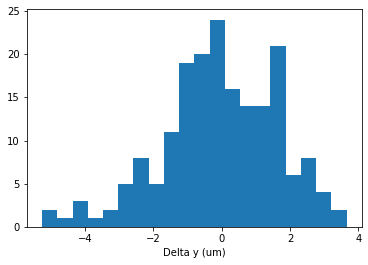

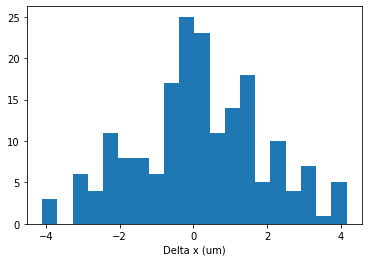

SD y: 1.7 +/- 0.0884um
Mean y: -0.0606 +/- 0.0542um
SD x: 1.72+/- 0.0891 um
Mean x: 0.174 +/- 0.0489 um


In [29]:
xvec = TrackData['x'].values
xvecum = np.array(pixeltoumx(xvec))
# Find the difference in xvec by some number of frames in the video 
offset = 6
xdiff6 = xvecum[offset:]-xvecum[:-offset]


yvec = TrackData['y'].values
yvecum = np.array(pixeltoumy(yvec))
# Find the difference in xvec by some number of frames in the video 
offset = 6
ydiff6 = yvecum[offset:]-yvecum[:-offset]

N= 2*len(xdiff6)
SDErrorFrac = (1)/(np.sqrt(N))


plt.hist(ydiff6, 20)
plt.xlabel('Delta y (um)')
plt.show()
sdy6 = np.std(ydiff6)

plt.hist(xdiff6, 20)
plt.xlabel('Delta x (um)')
plt.show()
sdx6 = np.std(xdiff6)
#FracErrorSD = 1/(np.sqrt(2(191)))
SDErrorAbsx6 = sdx6*SDErrorFrac
SDErrorAbsy6 = sdy6*SDErrorFrac

Meany = np.mean(ydiff6)
print (f"SD y: {sdy6:.3} +/- {SDErrorAbsy6:.3}um")
print(f"Mean y: {Meany:.3} +/- {ErrorSEMy:.3}um")

Meanx = np.mean(xdiff6)
print (f"SD x: {sdx6:.3}+/- {SDErrorAbsx6:.3} um")
print(f"Mean x: {Meanx:.3} +/- {ErrorSEMx:.3} um")

RMS6s = (sdx6**2+sdy6**2)/2


SDx6frac = SDErrorAbsx6/(sdx6)
SDy6frac = SDErrorAbsy6/(sdy6)

RMSx6frac = SDx6frac*2
RMSy6frac = SDy6frac*2

RMSxabs6 = RMSx6frac*(sdx6**2)
RMSyabs6 = RMSy6frac*(sdy6**2)

RMS6Error = np.sqrt(((RMSxabs6)**2)+((RMSyabs6)**2))

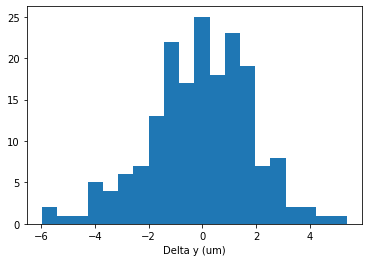

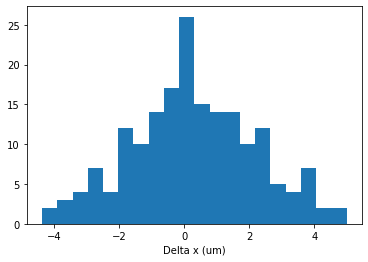

SD y: 1.94 +/- 0.101um
Mean y: -0.0993 +/- 0.0542um
SD x: 1.91+/- 0.0998 um
Mean x: 0.28 +/- 0.0489 um


In [30]:
xvec = TrackData['x'].values
xvecum = np.array(pixeltoumx(xvec))
# Find the difference in xvec by some number of frames in the video 
offset = 8
xdiff8 = xvecum[offset:]-xvecum[:-offset]


yvec = TrackData['y'].values
yvecum = np.array(pixeltoumy(yvec))
# Find the difference in xvec by some number of frames in the video 
offset = 8
ydiff8 = yvecum[offset:]-yvecum[:-offset]

N= 2*len(xdiff8)
SDErrorFrac = (1)/(np.sqrt(N))

plt.hist(ydiff8, 20)
plt.xlabel('Delta y (um)')
plt.show()
sdy8 = np.std(ydiff8)

plt.hist(xdiff8, 20)
plt.xlabel('Delta x (um)')
plt.show()
sdx8 = np.std(xdiff8)
#FracErrorSD = 1/(np.sqrt(2(191)))
SDErrorAbsx8 = sdx8*SDErrorFrac
SDErrorAbsy8 = sdy8*SDErrorFrac

Meany = np.mean(ydiff8)
print (f"SD y: {sdy8:.3} +/- {SDErrorAbsy8:.3}um")
print(f"Mean y: {Meany:.3} +/- {ErrorSEMy:.3}um")

Meanx = np.mean(xdiff8)
print (f"SD x: {sdx8:.3}+/- {SDErrorAbsx8:.3} um")
print(f"Mean x: {Meanx:.3} +/- {ErrorSEMx:.3} um")

RMS8s = (sdx8**2+sdy8**2)/2

SDx8frac = SDErrorAbsx8/(sdx8)
SDy8frac = SDErrorAbsy8/(sdy8)

RMSx8frac = SDx8frac*2
RMSy8frac = SDy8frac*2

RMSx8abs = RMSx8frac*(sdx8**2)
RMSy8abs = RMSy8frac*(sdy8**2)

RMS8Error = np.sqrt(((RMSx8abs)**2)+((RMSy8abs)**2))

0.052414241836095915


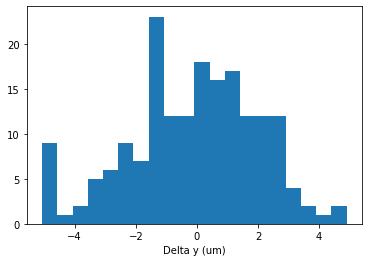

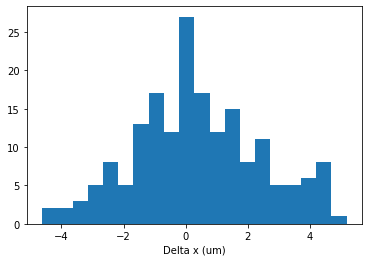

SD y: 2.11 +/- 0.11um
Mean y: -0.118 +/- 0.0542um
SD x: 2.03+/- 0.106 um
Mean x: 0.399 +/- 0.0489 um


In [31]:
xvec = TrackData['x'].values
xvecum = np.array(pixeltoumx(xvec))
# Find the difference in xvec by some number of frames in the video 
offset = 10
xdiff10 = xvecum[offset:]-xvecum[:-offset]


yvec = TrackData['y'].values
yvecum = np.array(pixeltoumy(yvec))
# Find the difference in xvec by some number of frames in the video 
offset = 10
ydiff10 = yvecum[offset:]-yvecum[:-offset]

N= 2*len(xdiff10)
SDErrorFrac = (1)/(np.sqrt(N))
print(SDErrorFrac)

plt.hist(ydiff10, 20)
plt.xlabel('Delta y (um)')
plt.show()
sdy10 = np.std(ydiff10)

plt.hist(xdiff10, 20)
plt.xlabel('Delta x (um)')
plt.show()
sdx10 = np.std(xdiff10)
#FracErrorSD = 1/(np.sqrt(2(191)))
SDErrorAbsx10 = sdx10*SDErrorFrac
SDErrorAbsy10 = sdy10*SDErrorFrac

Meany = np.mean(ydiff10)
print (f"SD y: {sdy10:.3} +/- {SDErrorAbsy10:.3}um")
print(f"Mean y: {Meany:.3} +/- {ErrorSEMy:.3}um")

Meanx = np.mean(xdiff10)
print (f"SD x: {sdx10:.3}+/- {SDErrorAbsx10:.3} um")
print(f"Mean x: {Meanx:.3} +/- {ErrorSEMx:.3} um")

RMS10s = (sdx10**2+sdy10**2)/2
#RMS10Error = np.sqrt(((SDErrorAbsx10)**2)+((SDErrorAbsy10)**2))/2


SDx10frac = SDErrorAbsx10/(sdx10)
SDy10frac = SDErrorAbsy10/(sdy10)

RMSx10frac = SDx10frac*2
RMSy10frac = SDy10frac*2

RMSx10abs = RMSx10frac*(sdx10**2)
RMSy10abs = RMSy10frac*(sdy10**2)

RMS10Error = np.sqrt(((RMSx10abs)**2)+((RMSy10abs)**2))
RMSFrac = RMS10Error/RMS10s

Here I created a table of the variances, the respective change in time offsets, and the variance errors.

In [32]:
from tabulate import tabulate as tab
RMS = [RMS1s,RMS2s,RMS4s,RMS6s,RMS8s,RMS10s]
RMSError = [RMS1Error*2,RMS2Error*2,RMS4Error*2,RMS6Error*2,RMS8Error*2,RMS10Error*2]
Ts = [1,2,4,6,8,10]
table = [['Delta T (s)', 'RMS (um)', 'RMS Error(um)'],
      [1, RMS[0],RMSError[0]],
      [2, RMS[1],RMSError[1]],
      [4, RMS[2],RMSError[2]],
      [6, RMS[3],RMSError[3]],
      [8, RMS[4],RMSError[4]],
      [10, RMS[5],RMSError[5]]]
print(tab(table))

-----------  ------------------  -------------------
Delta T (s)  RMS (um)            RMS Error(um)
1            0.5083059817201907  0.14826988412298336
2            1.0470682360426982  0.3050410677350383
4            2.0062360425992685  0.46254800029717275
6            2.927534416319841   0.8586572129936569
8            3.713502772727853   1.0951481352720682
10           4.2848320417768875  1.2713039217215527
-----------  ------------------  -------------------


The linear fit calculation of D is 0.426 +/- 14.8% um^2/s


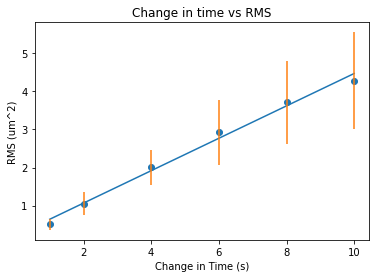

In [33]:
plt.scatter(Ts, RMS)
a, b = np.polyfit(Ts, RMS, 1)
plt.plot(Ts, a*(np.array(Ts))+b)
plt.errorbar(Ts,RMS ,xerr = None, yerr = RMSError, ls = 'none')
plt.xlabel('Change in Time (s)')
plt.ylabel("RMS (um^2)")
plt.title('Change in time vs RMS')
print(f'The linear fit calculation of D is {a:.3} +/- 14.8% um^2/s')

The value of D which we just found by applying a linear fit to the plot of RMS vs change in time is within the errors of each measurement, but the fit based calculation is quite a bit bigger, and also quite uncertain. With the error on the slope based D being the fractional uncertainty in the variance RMS with a value of +/-14.8% error. It is difficult to say what could have caused this disparity, and perhaps because we kept our delta t values below 10 seconds, there isnt really any evidence that the RMS vs T relationship is anything but linear. Althought before fitting, the data looked slightly like a square root graph, after fitting it seems to be clearly linear. 